# Quickstart: NOAA GEFS forecast, 35 day - dynamical.org zarr
A brief introduction to the NOAA GEFS forecast dataset transformed into an analysis-ready, cloud-optimized format by dynamical.org.

Dataset documentation: https://dynamical.org/catalog/noaa-gefs-forecast-35-day/


In [1]:
# Install dependencies required for this example.
# If you're not using pip to install depdencies (for example, you're using conda or uv),
# skip this cell and and install using the package manager of your choice.
# Restart the notebook after installing dependencies.
%pip install "xarray[complete]>=2025.1.2" "zarr>=3.0.4" requests aiohttp
!apt-get install -y libproj-dev proj-data proj-bin libgeos-dev
!pip install cython
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 1.6 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Don

Usando init_time: 2025-03-26 00:00:00


<ipython-input-7-80d9bdba6bf2>:66: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.02)  # Más juntos


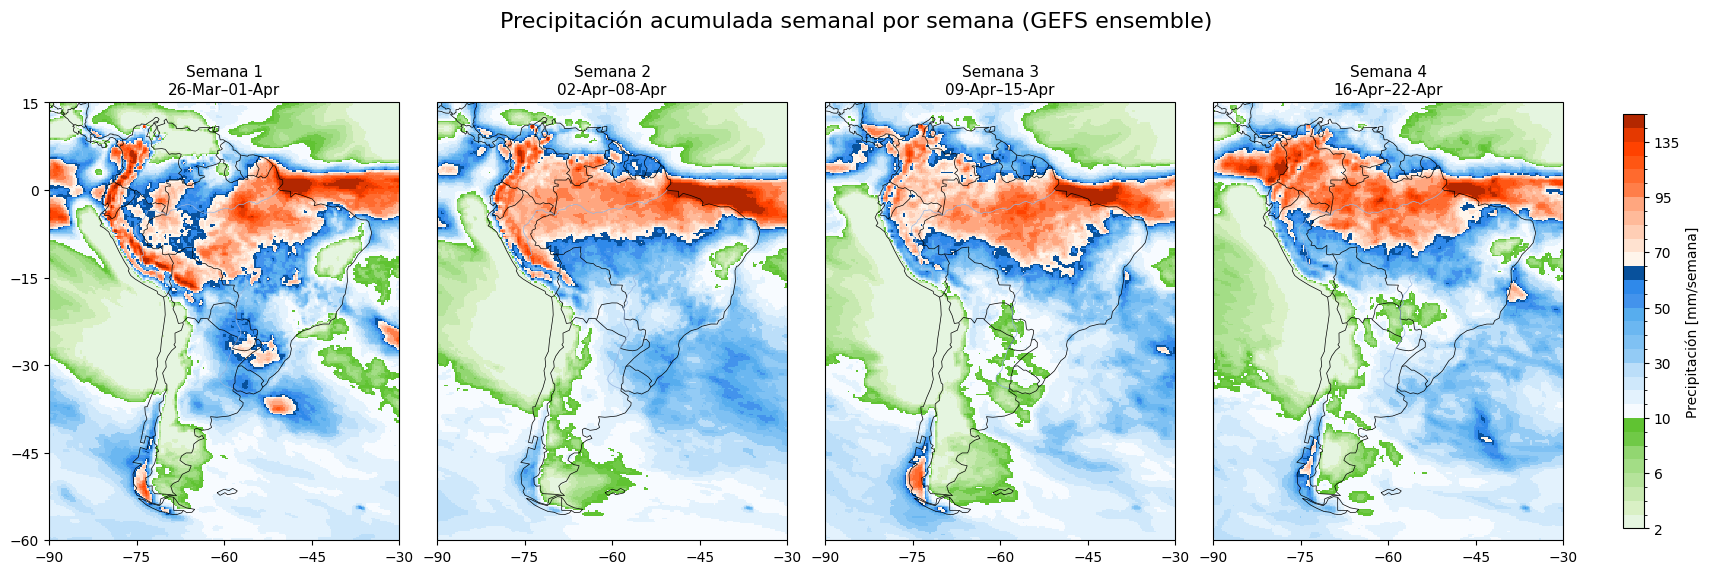

In [7]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# 1️⃣ Abrir dataset GEFS desde Zarr
ds = xr.open_zarr(
    "https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com",
    decode_timedelta=True
)

# 2️⃣ Fecha más reciente
latest_init = ds.init_time.max().values
print("Usando init_time:", pd.to_datetime(latest_init))

# 3️⃣ Subconjunto Sudamérica y promedio ensemble
ds_mean = (
    ds.sel(init_time=latest_init)
    .sel(latitude=slice(15, -60), longitude=slice(-90, -30))
    .mean(dim="ensemble_member")
)

# 4️⃣ Semana 1 a 4: lead_time hasta 27 días
ds_weeks = ds_mean.sel(lead_time=slice("0h", "27d"))

# 5️⃣ Paso en segundos
lead_times = ds_weeks.lead_time
dt = lead_times.diff("lead_time").dt.total_seconds()
last_dt = dt[-1]
dt_full = xr.concat([dt, last_dt.expand_dims(lead_time=1)], dim="lead_time")
dt_seconds = xr.DataArray(dt_full.values, coords={"lead_time": ds_weeks.lead_time}, dims=["lead_time"])

# 6️⃣ Convertir a mm
precip_mm = ds_weeks["precipitation_surface"] * dt_seconds

# 7️⃣ Coordenada temporal real
forecast_time = ds_weeks.init_time + ds_weeks.lead_time
precip_mm = precip_mm.assign_coords(forecast_time=forecast_time)
precip_mm = precip_mm.swap_dims({"lead_time": "forecast_time"})

# 8️⃣ Agrupar por día calendario
precip_daily = precip_mm.groupby("forecast_time.date").sum(dim="forecast_time")

# 9️⃣ Preparar semanas
semanas = {
    "Semana 1": slice(0, 7),
    "Semana 2": slice(7, 14),
    "Semana 3": slice(14, 21),
    "Semana 4": slice(21, 28),
}

# 🔟 Paleta personalizada
colors_prec = (
    ["#E5F5E0", "#D9F0C5", "#C7E9B0", "#B5E39B", "#A3DD86", "#92D671", "#81D05C", "#70C947", "#60C332"] +
    ["#F7FBFF", "#E3F2FD", "#CFE8FB", "#BBDEF9", "#A7D5F7", "#93CBF5", "#7FC1F3", "#6BB7F1", "#57ADEE", "#4393EC", "#2F89EA", "#1B7FE8", "#08519C"] +
    ["#FFF5EB", "#FFE2D0", "#FFCEB5", "#FFBA9A", "#FFA67F", "#FF9264", "#FF7E49", "#FF6A2E", "#FF5613", "#FF4200", "#E53900", "#CC3000", "#B32700"]
)
levels_prec = list(range(2, 10, 1)) + list(range(10, 85, 5)) + list(range(85, 160, 10))
cmap_prec = mcolors.ListedColormap(colors_prec)
norm_prec = mcolors.BoundaryNorm(levels_prec, cmap_prec.N)

# 🎨 Crear figura con 4 subplots en una fila
fig, axes = plt.subplots(1, 4, figsize=(17, 6), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
plt.subplots_adjust(wspace=0.02)  # Más juntos

for i, (ax, (semana, rango)) in enumerate(zip(axes, semanas.items())):
    # Acumulado semanal
    prec = precip_daily.isel(date=rango).sum(dim="date")

    # Fechas del rango
    week_dates = precip_daily.date.values[rango]
    start_date = pd.to_datetime(str(week_dates[0])).strftime("%d-%b")
    end_date = pd.to_datetime(str(week_dates[-1])).strftime("%d-%b")

    # Mapa base
    ax.set_extent([-90, -30, -60, 15], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.RIVERS, linewidth=0.5)

    # Etiquetas solo en eje izquierdo e inferior
    if i == 0:
        ax.set_yticks(range(-60, 16, 15), crs=ccrs.PlateCarree())
        ax.set_xticks(range(-90, -29, 15), crs=ccrs.PlateCarree())
        ax.tick_params(labelleft=True, labelbottom=True)
    else:
        ax.tick_params(labelleft=False, labelbottom=True)
        ax.set_xticks(range(-90, -29, 15), crs=ccrs.PlateCarree())

    # Plot
    mesh = ax.pcolormesh(prec.longitude, prec.latitude, prec, cmap=cmap_prec, norm=norm_prec, shading="auto")
    ax.set_title(f"{semana}\n{start_date}–{end_date}", fontsize=11)

# Colorbar global
cbar = fig.colorbar(mesh, ax=axes.ravel().tolist(), orientation="vertical", shrink=0.7, pad=0.03)
cbar.set_label("Precipitación [mm/semana]")

# Título general
plt.suptitle("Precipitación acumulada semanal por semana (GEFS ensemble)", fontsize=16, y=1.02)
plt.show()


Usando init_time: 2025-03-26 00:00:00


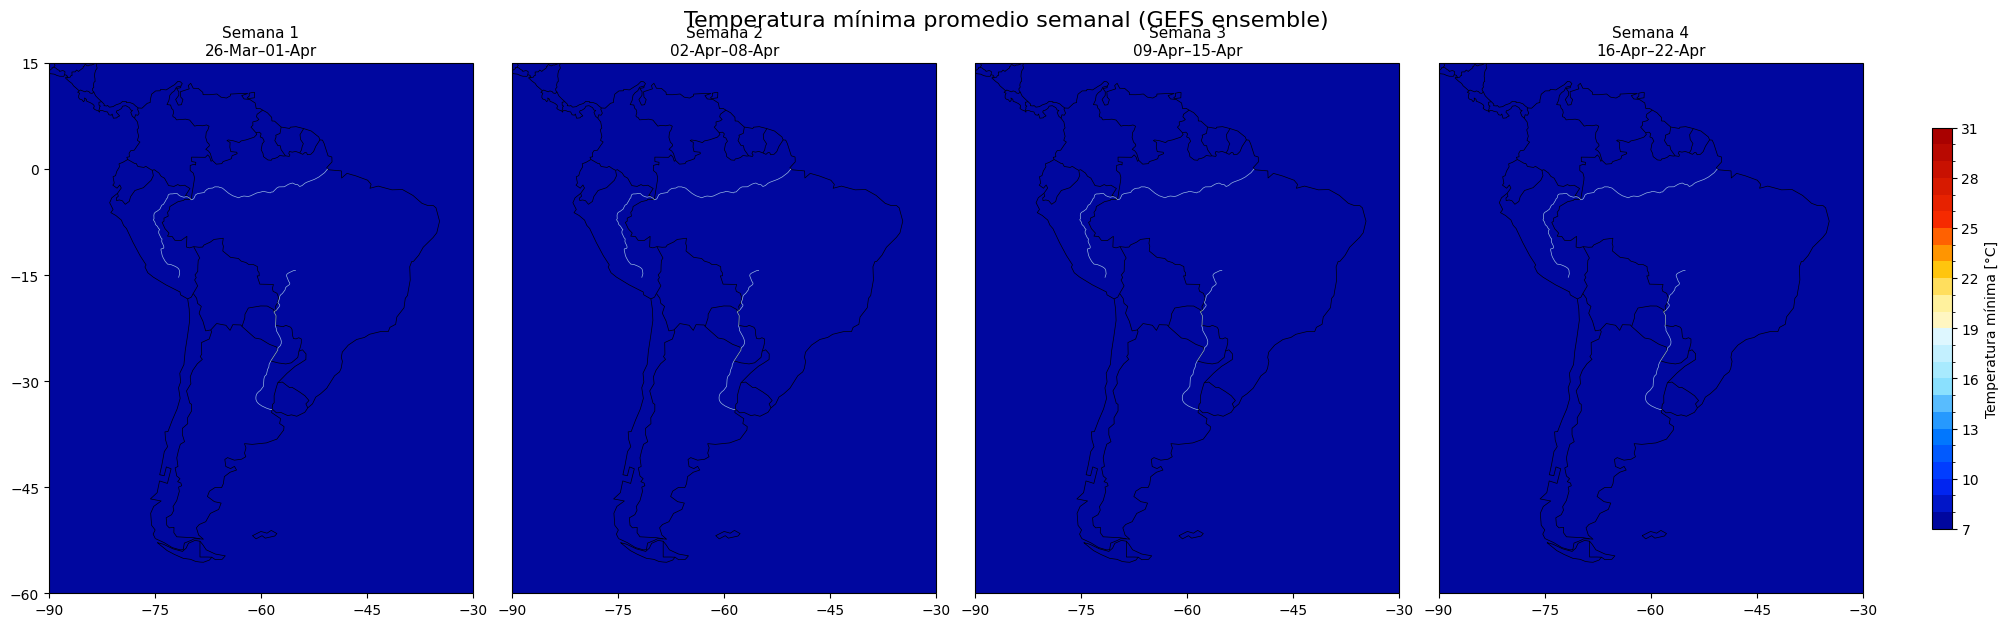

In [9]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np

# 1️⃣ Abrir dataset GEFS desde Zarr
ds = xr.open_zarr(
    "https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com",
    decode_timedelta=True
)

# 2️⃣ Fecha más reciente
latest_init = ds.init_time.max().values
print("Usando init_time:", pd.to_datetime(latest_init))

# 3️⃣ Subconjunto Sudamérica y promedio ensemble
ds_mean = (
    ds.sel(init_time=latest_init)
    .sel(latitude=slice(15, -60), longitude=slice(-90, -30))
    .mean(dim="ensemble_member")
)

# 4️⃣ Hasta 28 días para cubrir 4 semanas
ds_weeks = ds_mean.sel(lead_time=slice("0h", "27d"))

# 5️⃣ Variable: temperatura mínima
tmin = ds_weeks["minimum_temperature_2m"]

# 6️⃣ Coordenada temporal real
forecast_time = ds_weeks.init_time + ds_weeks.lead_time
tmin = tmin.assign_coords(forecast_time=forecast_time)
tmin = tmin.swap_dims({"lead_time": "forecast_time"})

# 7️⃣ Agrupar por fecha calendario y hacer promedio diario
tmin_daily = tmin.groupby("forecast_time.date").mean(dim="forecast_time")

# 8️⃣ Preparar semanas (promedio semanal)
semanas = {
    "Semana 1": slice(0, 7),
    "Semana 2": slice(7, 14),
    "Semana 3": slice(14, 21),
    "Semana 4": slice(21, 28),
}

# 9️⃣ Paleta de colores personalizada para temperatura mínima [°C]
colors_temp = ['#00079F', '#0116C8', '#0125F0', '#013DFF', '#015AFE', '#0177FE', '#2699FE', '#58BCFE',
               '#8AE0FE', '#A8EAFE', '#C3F0FF', '#DEF7FF',  '#FFF6C1', '#FFF19D', '#FFDE5D', '#FFC50E',
               '#FF9501', '#FF6101', '#F62A00', '#E72200', '#D71A00', '#C81101', '#B80901', '#A90100']
cmap_temp = mcolors.ListedColormap(colors_temp)
norm_temp = mcolors.BoundaryNorm(boundaries=np.arange(7, 32, 1), ncolors=len(colors_temp))

# 🔟 Crear figura
fig, axes = plt.subplots(1, 4, figsize=(20, 6), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
plt.subplots_adjust(wspace=0.02)

for i, (ax, (semana, rango)) in enumerate(zip(axes, semanas.items())):
    # Promedio semanal (en K), convertir a °C
    tmin_week = tmin_daily.isel(date=rango).mean(dim="date") - 273.15

    # Fechas de la semana
    week_dates = tmin_daily.date.values[rango]
    start_date = pd.to_datetime(str(week_dates[0])).strftime("%d-%b")
    end_date = pd.to_datetime(str(week_dates[-1])).strftime("%d-%b")

    # Mapa base
    ax.set_extent([-90, -30, -60, 15], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.RIVERS, linewidth=0.5)

    # Etiquetas de ejes
    if i == 0:
        ax.set_yticks(range(-60, 16, 15), crs=ccrs.PlateCarree())
        ax.set_xticks(range(-90, -29, 15), crs=ccrs.PlateCarree())
        ax.tick_params(labelleft=True, labelbottom=True)
    else:
        ax.tick_params(labelleft=False, labelbottom=True)
        ax.set_xticks(range(-90, -29, 15), crs=ccrs.PlateCarree())

    # Graficar temperatura mínima
    mesh = ax.pcolormesh(
        tmin_week.longitude,
        tmin_week.latitude,
        tmin_week,
        cmap=cmap_temp,
        norm=norm_temp,
        shading="auto"
    )

    ax.set_title(f"{semana}\n{start_date}–{end_date}", fontsize=11)

# Colorbar común
cbar = fig.colorbar(mesh, ax=axes.ravel().tolist(), orientation="vertical", shrink=0.7, pad=0.03)
cbar.set_label("Temperatura mínima [°C]")

# Título principal
plt.suptitle("Temperatura mínima promedio semanal (GEFS ensemble)", fontsize=16, y=1.02)
plt.show()


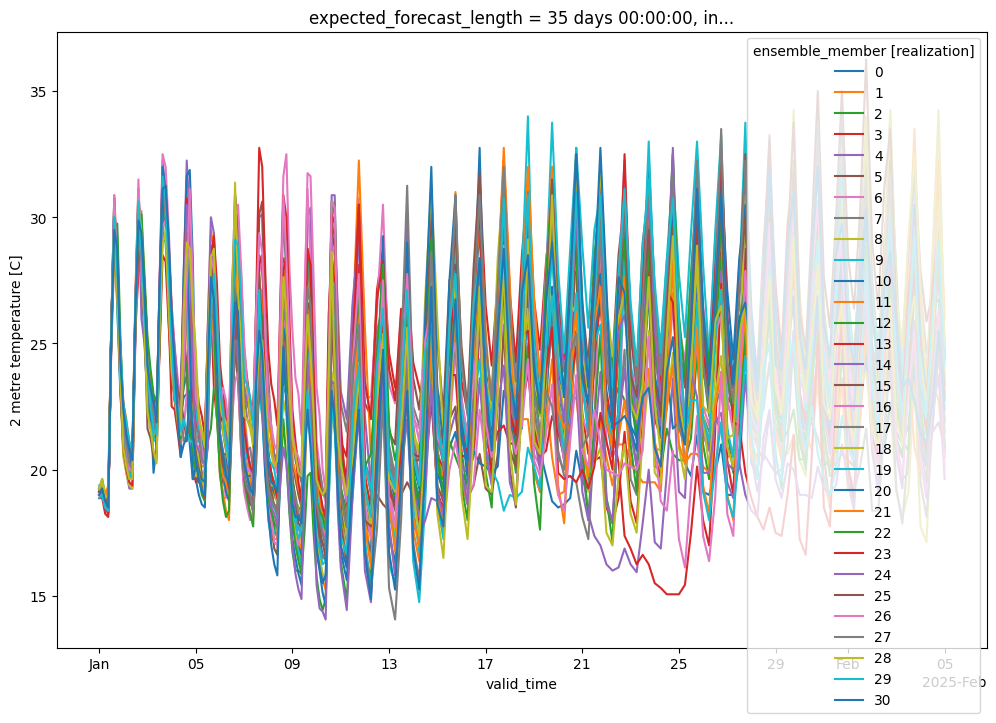

In [ ]:
# Plot the ensemble traces of the 2025-01-01 forecast at a point on the earth
plot_ds = ds.sel(init_time="2025-01-01T00", latitude=-23.5, longitude=-46.6, method="nearest")  # São Paulo, Brazil
_ = plot_ds["temperature_2m"].plot(x="valid_time", hue="ensemble_member", figsize=(12, 8))

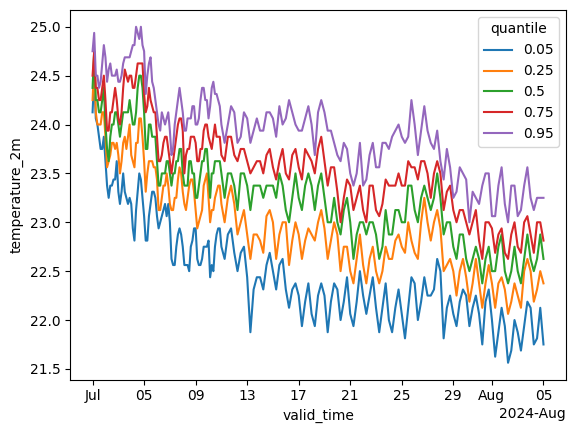

In [ ]:
# Plot a summary of the ensemble distribution using quantiles
plot_ds = ds.sel(init_time="2024-07-01T00", latitude=0, longitude=0)
(
    plot_ds["temperature_2m"]
    .quantile([0.05, 0.25, 0.5, 0.75, 0.95], dim="ensemble_member")
    .plot(x="valid_time", hue="quantile")
)

In [ ]:
# The following larger area examples run faster using dask which happens by default if you omit chunks=None
ds = xr.open_zarr("https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com", decode_timedelta=True)

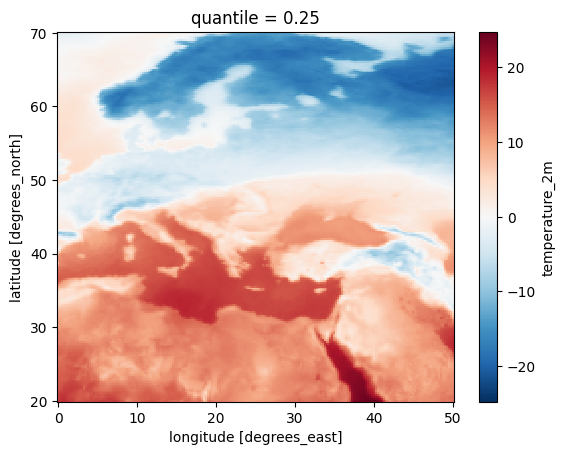

In [ ]:
# Calculate a quantile across ensemble members and display the result as a map
(
    ds["temperature_2m"]
    .sel(init_time="2025-01-01T00")
    .sel(lead_time="7d")
    .sel(latitude=slice(70, 20), longitude=slice(0, 50))
    .quantile(0.25, dim="ensemble_member") # 25% chance it gets colder than this
    .plot()
)

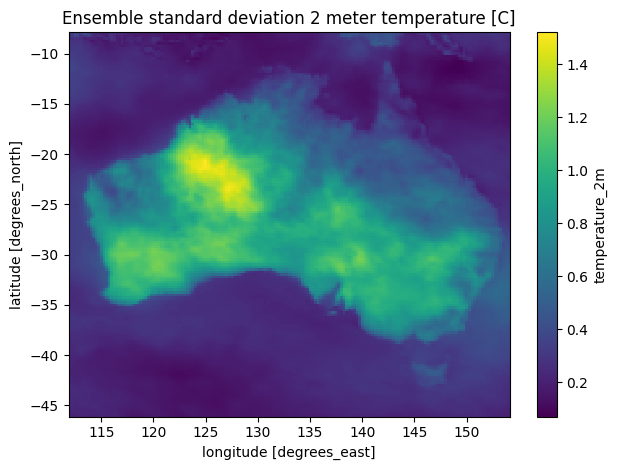

In [ ]:
# Highlight areas of uncertainty in temperature forecast over the first 7 days of 2025

import matplotlib.pyplot as plt

plot_ds = (
    ds.sel(init_time="2024-03-01T00")
    .sel(latitude=slice(-8, -46), longitude=slice(112, 154))  # Australia
    .sel(lead_time=slice("0h", "6d")).mean(dim="lead_time")  # Average the first week of the forecast
)

# Standard deviation across ensemble members to highlight regions of forecast uncertainty
plot_ds["temperature_2m"].std(dim="ensemble_member").plot()
plt.title(f"Ensemble standard deviation 2 meter temperature [{ds['temperature_2m'].attrs['units']}]")

plt.tight_layout()